## Imports and Path/Variable Definitions

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py
from scipy import signal
import argparse
import seaborn as sns
from datetime import date
import os
import X_gnss_unet_datagen_fn22 # Module with CNN/data generator code

2024-10-09 14:02:19.832985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-09 14:02:19.833011: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:


sns.set_style('white')

project_name = 'newfault' # Based on the name of the FakeQuakes project
fq_dir = '/hdd/rc_fq/fall24/' # Where are the FakeQuakes stored? (The final .hdf5 file)
noise_dir = '/home/sdybing/gnss-picker/data/noisedata/' # Where is the noise data stored?
realdata_dir = '/home/sdybing/gnss-picker/data/realdata/summer23/' # Where is the real data stored?

cnn_save_dir = '/home/sdybing/gnss-picker/cnn_models_outputs/' # Where do you want to save this code's outputs?
project_save_dir = cnn_save_dir + project_name + '_fq_train/'
base_figure_save_dir = project_save_dir + 'base_data_figures/' # Where to save the figures of just the data/generator tests
models_path = project_save_dir + 'models/'
if os.path.isdir(project_save_dir):
    pass
else:
    os.makedirs(project_save_dir)
    os.makedirs(base_figure_save_dir)
    os.makedirs(models_path)
    
train = False # Do you want to train?
drop = 1 # Drop?
resume = 0 # Resume training
large = 0.5 # Large unet
fac = large
epochs = 100 # How many epochs?
std = 3 # How long do you want the Gaussian STD to be?
sr = 1 # Sample rate (Hz)
epsilon = 1e-6
batch_size = 32
load = True # Loading an old trained model?
small_train = False # Train with a smaller amount of data to make sure code works?
small_test = False # Test with a smaller amount of data to make sure code works?

## Data Loading and Formatting

### Load the Data

In [ ]:
# FakeQuakes waveform data
print('Loading FakeQuakes...')
fq_data = h5py.File(fq_dir + 'newfault_fq_wvfm_data_formatted.hdf5', 'r')
fq_data = fq_data['data'][:,:]
# old_fq_data = h5py.File(fq_dir + 'july6_128samps_fq_wvfm_data_formatted.hdf5', 'r')
# old_fq_data = old_fq_data['data'][:,:]

# FakeQuakes metadata
print('Loading FakeQuakes metadata...')
fq_metadata = np.load(fq_dir + 'newfault_fq_wvfm_info.npy')

# Noise data
print('Loading noise...')
all_noise_data = h5py.File(noise_dir + 'summer23_128samps_all_noise_samples.hdf5', 'r')
all_noise_data = all_noise_data['all_noise_samples'][:,:]

# Demeaned real waveform data
print('Loading real data...')
real_data = h5py.File(realdata_dir + 'demean_realdata_rembad.hdf5', 'r')
real_data = real_data['demean_realdata_rembad'][:,:]

# Real metadata
print('Loading real metadata...')
real_metadata = np.load(realdata_dir + 'real_metadata_rembad_w_gauss_pos_mag.npy')

# Trim noise data to match length of FakeQuakes data
noise_data = all_noise_data[:len(fq_data)]

# Array of NaNs to use to match added noise in concatenation later
nan_array = np.empty((len(fq_data), 3))
nan_array[:] = np.NaN

# Real data

# Check shapes
print('FakeQuakes shape: ' + str(fq_data.shape))
print('Noise data shape: ' + str(noise_data.shape))
print('Real data shape: ' + str(real_data.shape))


In [ ]:
# # Finding bad ruptures (data all zeros) - uses normalized fq_data file
# No bad ruptures in july6 data

# inf_idxs = []

# for idx in range(len(fq_data)):
#     row = fq_data[idx]
#     check_nan = np.isnan(row)
#     check_inf = np.isinf(row)
#     l = np.where(check_nan == True)[0]
#     m = np.where(check_inf == True)[0]
    
#     if len(l) > 0 or len(m) > 0:
#         inf_idxs.append(idx)

# bad_rupts = []

# for i in inf_idxs:
# #     plt.plot(old_fq_data[i]) # Need to go back to 3a code and remove things that are all zero
# #     print(fq_metadata[i][0])
#     if fq_metadata[i][0] in bad_rupts:
#         pass
#     else:
#         bad_rupts.append(fq_metadata[i][0])

# # np.save('/hdd/rc_fq/summer23/july6_bad_rupts.npy', np.array(bad_rupts))


### Format and Split Training, Validation, and Testing Data

In [ ]:
np.random.seed(27)

# Earthquake/signal data
fqinds = np.arange(fq_data.shape[0]) # Signal indices
np.random.shuffle(fqinds) # Shuffles the indices
train_fqinds = fqinds[:int(0.8*len(fqinds))] # Training data separation: grabs the front 80% of the numbers
valid_fqinds = fqinds[int(0.8*len(fqinds)):int(0.9*len(fqinds)):] # Grabs the next 10% (80-90%)
test_fqinds = fqinds[int(0.9*len(fqinds)):] # Grabs the last 10% (90%-end)

# Noise data
noiseinds = np.arange(noise_data.shape[0]) # Noise indices
np.random.shuffle(noiseinds) # Shuffles the indices
train_noiseinds = noiseinds[:int(0.8*len(noiseinds))] # Data separation as above
valid_noiseinds = noiseinds[int(0.8*len(noiseinds)):int(0.9*len(noiseinds))]
test_noiseinds = noiseinds[int(0.9*len(noiseinds)):]

# Check shapes to confirm compatability
print('Full FakeQuakes data shape: ' + str(fqinds.shape))
print('FakeQuakes training data shape: ' + str(train_fqinds.shape))
print('FakeQuakes validation data shape: ' + str(valid_fqinds.shape))
print('FakeQuakes testing data shape: ' + str(test_fqinds.shape))
print('Full noise data shape: ' + str(noiseinds.shape))
print('Noise training data shape: ' + str(train_noiseinds.shape))
print('Noise validation data shape: ' + str(valid_noiseinds.shape))
print('Noise testing data shape: ' + str(test_noiseinds.shape))


### Check Loaded Data with Plots

In [ ]:
# Plot the FakeQuakes data
plt.figure(figsize = (8,5))   
plt.title('Earthquake test', fontsize = 14)
for idx in range(10): # plot 10 of them
    plt.plot(fq_data[idx,:] / np.max(np.abs(fq_data[idx,:])) + idx) # Normalized and offset for each idx
plt.axvline(256.5, linestyle = '--', color = 'lightgray')
plt.axvline(513.5, linestyle = '--', color = 'lightgray')
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Normalized amplitude', fontsize = 12)
plt.xlim(0,770)
plt.xticks([])
plt.yticks([])
plt.text(x = 5, y = -0.75, s = 'N', fontsize = 20)
plt.text(x = 261, y = -0.75, s = 'E', fontsize = 20)
plt.text(x = 518, y = -0.75, s = 'Z', fontsize = 20)

plt.show()
# plt.savefig(base_figure_save_dir + '1_plot_raw_eq_data.png', format = 'PNG')
# plt.close()

# Plot noise to check
plt.figure(figsize = (8,5))
plt.title('Noise test', fontsize = 14)
for idx in range(10):
    plt.plot(noise_data[idx,:] / np.max(np.abs(noise_data[idx,:])) + idx)
plt.axvline(256.5, linestyle = '--', color = 'lightgray')
plt.axvline(513.5, linestyle = '--', color = 'lightgray')
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Normalized amplitude', fontsize = 12)
plt.xlim(0,770)
plt.xticks([])
plt.yticks([])
plt.text(x = 5, y = -1.25, s = 'N', fontsize = 20)
plt.text(x = 261, y = -1.25, s = 'E', fontsize = 20)
plt.text(x = 518, y = -1.25, s = 'Z', fontsize = 20)

plt.show()
# plt.savefig(base_figure_save_dir + '2_plot_noise_data.png', format = 'PNG')
# plt.close()

# Check the PGD distribution

# testing_data = fq_data[test_fqinds]

# pgd = np.zeros(testing_data.shape[0]) # Reminder - FQ data is in meters
# for idx in range(testing_data.shape[0]):
#     pgd[idx] = np.max(np.sqrt((testing_data[idx,:257])**2 + (testing_data[idx,257:514])**2 + (testing_data[idx,514:])**2))

# plt.figure(figsize = (8,5))
# plt.hist(pgd, bins = 30, alpha = 0.5, edgecolor = 'black')
# plt.ylim(0,10000)
# plt.show()
# plt.close()


## Test of Data Generator

In [ ]:
checkgen = X_gnss_unet_datagen_fn22.my_3comp_data_generator(32, fq_data, noise_data, fq_metadata, nan_array, train_fqinds, train_noiseinds, sr, std, valid = True) # Valid = True to get original data back
checkgen_orig_data, checkgen_norm_data, checkgen_target, checkgen_metadata = next(checkgen) 

print('Data generator check original data shape: ' + str(checkgen_orig_data.shape))
print('Data generator check normalized data shape: ' + str(checkgen_norm_data.shape))
print('Data generator check target shape: ' + str(checkgen_target.shape))
print('Data generator check metadata shape: ' + str(checkgen_metadata.shape))

# Shapes:
    # data: (batch_size, 128, 3) # N, E, Z
    # target: (batch_size, 128)
    # metadata: (batch_size, 3) Rupt name, station name, magnitude

# Plot generator results

nexamples = 10 # Number of examples to look at 
  
for ind in range(nexamples): 
    
#     print('Magnitude: ' + str(metadata[ind,2]))

    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (26,4), dpi = 300) # shoter for AGU talk
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(checkgen_orig_data.shape[1])
    
    ax1 = plt.subplot(131)
    ax1.plot(t, checkgen_orig_data[ind,:,0]*100, label = 'N original data', color = 'C0')
    ax1.plot(t, checkgen_norm_data[ind,:,0]*100, label = 'N normalized data', color = 'C0', linestyle = '--')
    ax1.set_ylabel('Displacement (cm)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.set_ylabel('Confidence')
    ax2.legend(loc = 'lower right')
    
    ax3 = plt.subplot(132)
    ax3.plot(t, checkgen_orig_data[ind,:,1]*100, label = 'E original data', color = 'C1')
    ax3.plot(t, checkgen_norm_data[ind,:,1]*100, label = 'E normalized data', color = 'C1', linestyle = '--')
    ax3.set_ylabel('Displacement (cm)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.legend(loc = 'lower right')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, checkgen_orig_data[ind,:,2]*100, label = 'Z original data', color = 'C2')
    ax5.plot(t, checkgen_norm_data[ind,:,2]*100, label = 'Z normalized data', color = 'C2', linestyle = '--')
    ax5.set_ylabel('Displacement (cm)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.legend(loc = 'lower right')
    
    plt.show()
#     plt.savefig(base_figure_save_dir + '3_ex' + str(ind) + '_plot_generator_pass.png', format = 'PNG')
#     plt.close()


## Model Construction

In [3]:
if drop: # Use a model with a dropout layer
    model = X_gnss_unet_datagen_fn22.make_large_unet_drop(fac, sr, ncomps = 3)
    print('Using model with dropout')
else:
    model = X_gnss_unet_datagen_fn22.make_large_unet(fac, sr, ncomps = 3)  
    print('Using large model')
    

2024-10-09 14:02:25.113905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-09 14:02:25.114038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-10-09 14:02:25.114110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-10-09 14:02:25.114177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-10-09 14:02:25.114246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 16)      1024        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 64, 16)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64, 32)       7712        ['max_pooling1d[0][0]']          
                                                                                              

/home/sdybing/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 concatenate (Concatenate)      (None, 32, 128)      0           ['up_sampling1d[0][0]',          
                                                                  'conv1d_2[0][0]']               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 32, 32)       61472       ['concatenate[0][0]']            
                                                                                                  
 up_sampling1d_1 (UpSampling1D)  (None, 64, 32)      0           ['conv1d_4[0][0]']               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 64, 64)       0           ['up_sampling1d_1[0][0]',        
                                                                  'conv1d_1[0][0]']               
          

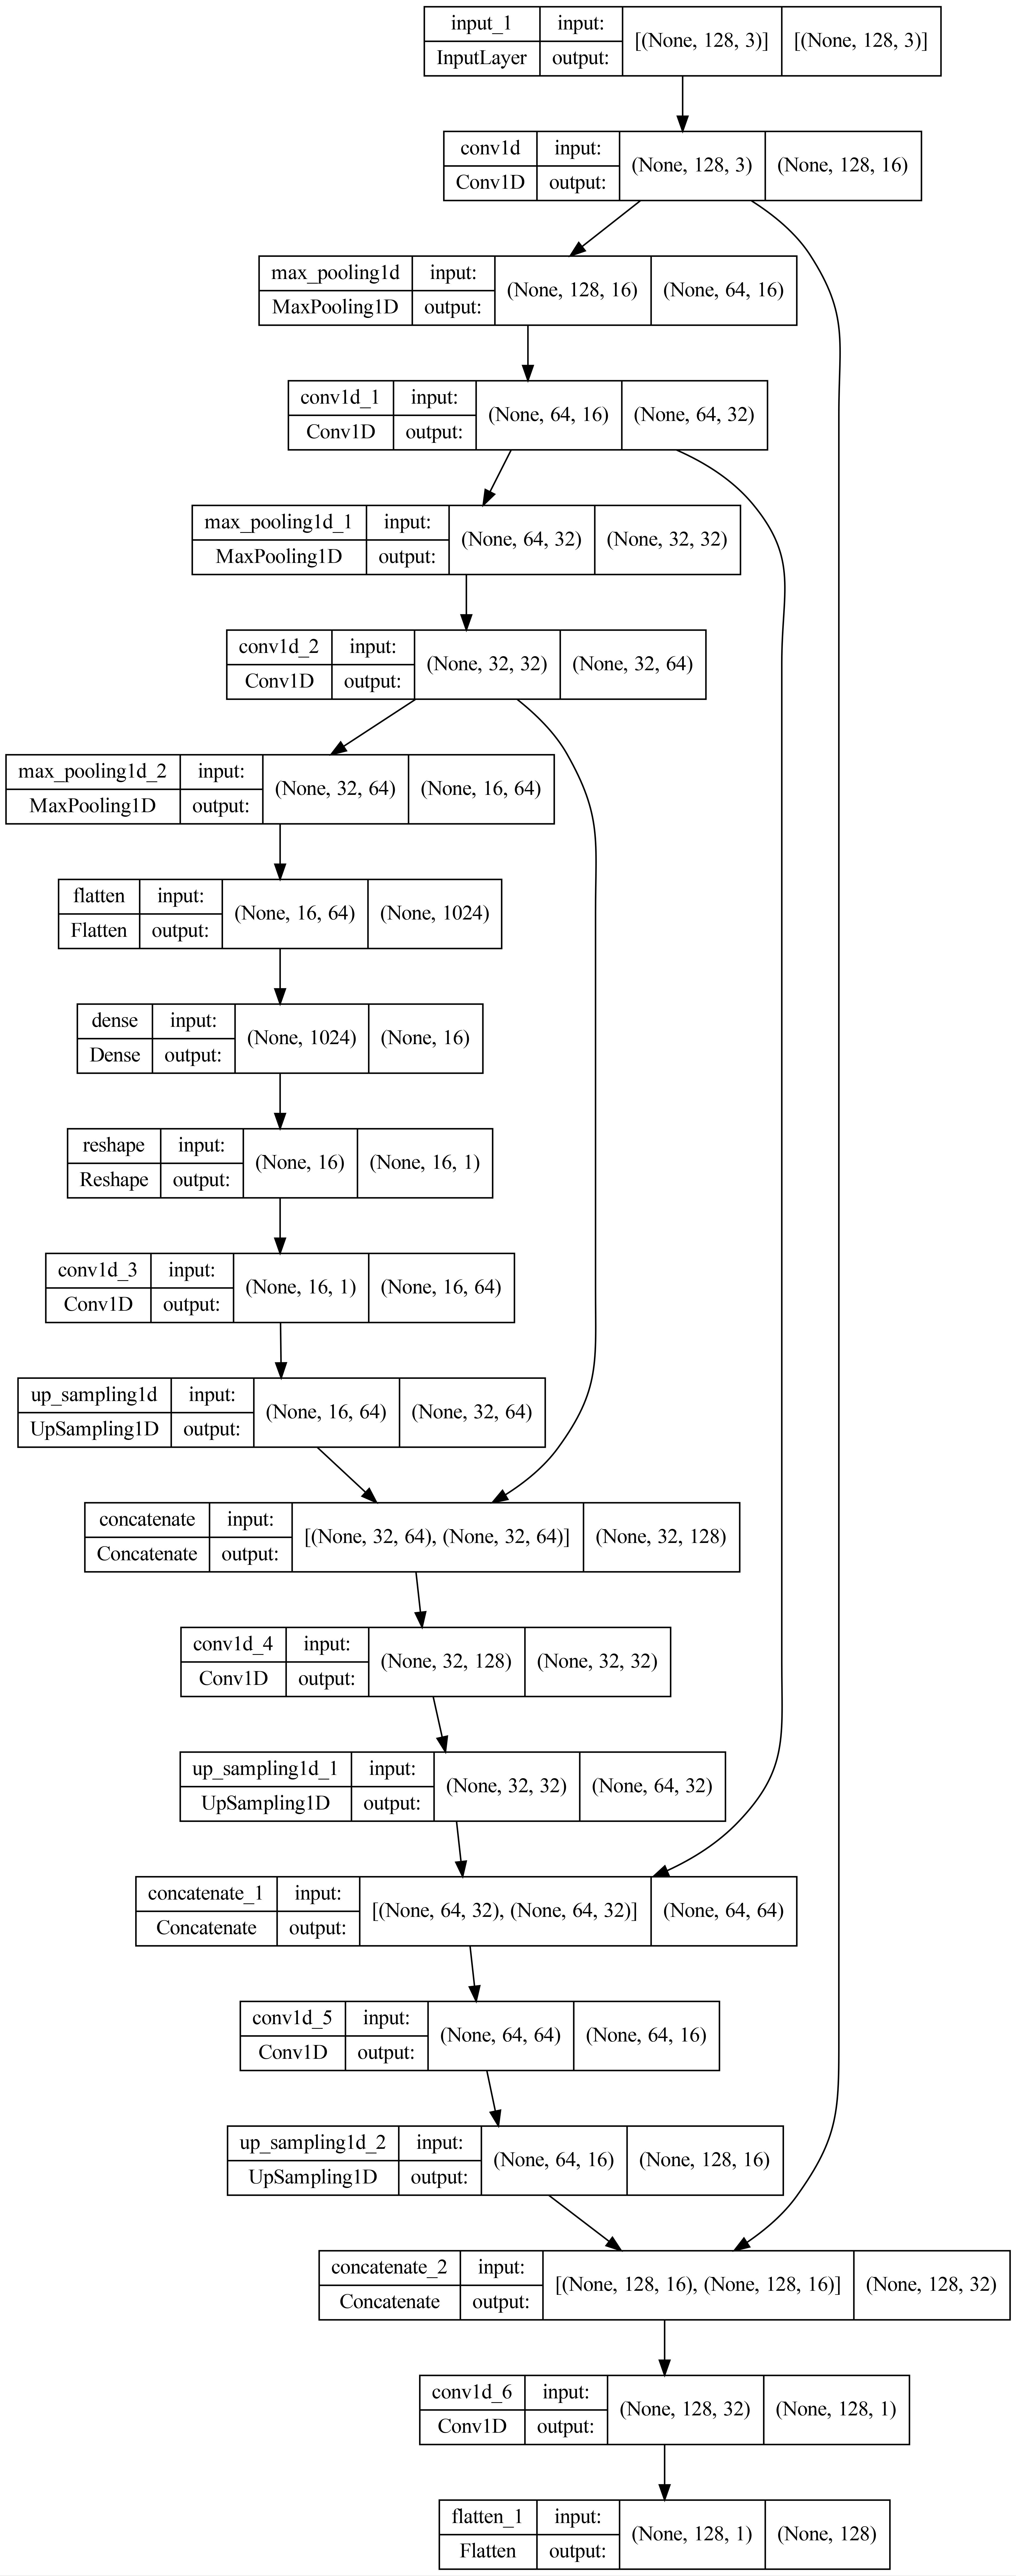

In [14]:
# Plot the model

tf.keras.utils.plot_model(model, to_file = '/home/sdybing/gnss-picker/manuscript_figures/model_structure.jpg', show_shapes = True, dpi = 400)
# tf.keras.utils.vis_utils.py.model_to_dot(model)

## Train the Model

### See how training works with a smaller dataset (faster)?

In [ ]:
if small_train:
    train_fqinds = train_fqinds[:10000]
    train_noiseinds = train_noiseinds[:10000]
    valid_fqinds = valid_fqinds[:10000]
    valid_noiseinds = valid_noiseinds[:10000]
    

### Train the model

In [ ]:
if train:
    
    traindate = date.today()
    
    model_save_dir = models_path + 'traindate_' + str(traindate) + '/' # Where to save the trained model
    data_save_dir = model_save_dir + 'data/' # Where to save the outputted testing data and predictions
    figure_save_dir = model_save_dir + 'figures/' # Where to save the figures
    
    if os.path.isdir(model_save_dir):
        pass
    else:
        os.makedirs(model_save_dir)
        os.makedirs(data_save_dir)
        os.makedirs(figure_save_dir)
    
    model_save_file = model_save_dir + 'bestmodel_traindate_' + str(traindate) + '.h5'
    
    print('Training model and saving results to ' + model_save_file)
    
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 4, min_lr = 0.5e-6)
    early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = model_save_file, monitor = 'val_loss', mode = 'auto', verbose = 1, save_best_only = True)
    callbacks = [lr_reducer, early_stopping_monitor, checkpoint]
    
    # Is it training from the normalized data or the original data? 
    # Answer - normalized. That's what's in the yield statement in the .py
    
    history = model.fit(X_gnss_unet_datagen_fn22.my_3comp_data_generator(batch_size, fq_data, noise_data, fq_metadata, nan_array, train_fqinds, train_noiseinds, sr, std), # Valid = False for training; implied
                        steps_per_epoch = (len(train_fqinds) + len(train_noiseinds))//batch_size,
                        validation_data = X_gnss_unet_datagen_fn22.my_3comp_data_generator(batch_size, fq_data, noise_data, fq_metadata, nan_array, valid_fqinds, valid_noiseinds, sr, std),
                        validation_steps = (len(valid_fqinds) + len(valid_noiseinds))//batch_size,
                        epochs = epochs, callbacks = callbacks)
    
    model.save_weights(model_save_file)
    np.save(model_save_dir + 'training_history.npy', history.history)
    

### Check Training Curves

In [ ]:
if train:
    
    history = np.load(model_save_dir + 'training_history.npy', allow_pickle = 'TRUE').item()

    fig = plt.subplots(nrows = 2, ncols = 1, figsize = (6,8))

    ax1 = plt.subplot(211)
    ax1.plot(history['loss'], label = 'Training loss')
    ax1.plot(history['val_loss'], label = 'Validation loss') 
    ax1.legend(loc = 'upper right')
    ax1.set_ylabel('Loss')
    ax1.set_title('Model: traindate_' + str(traindate) + '.h5')

    ax2 = plt.subplot(212)
    ax2.plot(history['accuracy'], label = 'Training accuracy') 
    ax2.plot(history['val_accuracy'], label = 'Validation accuracy') 
    ax2.legend(loc = 'lower right')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')

    plt.subplots_adjust(hspace = 0)

#     plt.show()
    plt.savefig(figure_save_dir + '4_training_curves.png', format = 'PNG')
    plt.close()


## Load an old trained model?

In [ ]:
if load:
    loaddate = '2024-10-01' # Format: YYYY-MM-DD
    model_load_file = project_save_dir + 'models/traindate_' + str(loaddate) + '/bestmodel_traindate_' + str(loaddate) + '.h5'
    data_save_dir = models_path + 'traindate_' + str(loaddate) + '/data/' # Where to save the outputted testing data and predictions
    figure_save_dir = models_path + 'traindate_' + str(loaddate) + '/figures/'
    print('Loading training results from ' + model_load_file)
    
    model.load_weights(model_load_file)

## Test the Model with Remaining FakeQuakes Data

### See how testing works with a smaller dataset (faster)?

In [ ]:
if small_test:
    test_fqinds = test_fqinds[:100]
    test_noiseinds = test_noiseinds[:100]
    

### Test the model

In [ ]:
fqtestdate = date.today()
num_fqtest = len(test_fqinds) - 3 # Number of samples to test with
# print(num_fqtest)

fqtestmodel = X_gnss_unet_datagen_fn22.my_3comp_data_generator(num_fqtest, fq_data, noise_data, fq_metadata, nan_array, test_fqinds, test_noiseinds, sr, std, valid = True)
fqtest_orig_data, fqtest_norm_data, fqtest_target, fqtest_metadata = next(fqtestmodel)
print('Predicting...')
fqtest_predictions = model.predict(fqtest_norm_data)

print('FQ test original data shape: ' + str(fqtest_orig_data.shape))
print('FQ test normalized data shape: ' + str(fqtest_norm_data.shape))
print('FQ test metadata shape: ' + str(fqtest_metadata.shape))
print('FQ test target shape: ' + str(fqtest_target.shape))
print('FQ test predictions shape: ' + str(fqtest_predictions.shape))


In [ ]:
# # Testing with validation data

# fqtestdate = date.today()
# num_fqtest = len(valid_fqinds) - 2 # Number of samples to test with
# # print(num_fqtest)

# fqtestmodel = X_gnss_unet_datagen_fn9.my_3comp_data_generator(num_fqtest, fq_data, noise_data, fq_metadata, nan_array, valid_fqinds, valid_noiseinds, sr, std, valid = True)
# fqtest_data, fqtest_target, fqtest_metadata = next(fqtestmodel)
# print('Predicting...')
# fqtest_predictions = model.predict(fqtest_data)

# print('FQ test data shape: ' + str(fqtest_data.shape))
# print('FQ test metadata shape: ' + str(fqtest_metadata.shape))
# print('FQ test target shape: ' + str(fqtest_target.shape))
# print('FQ test predictions shape: ' + str(fqtest_predictions.shape))

# np.save(data_save_dir + str(fqtestdate) + '_fqvalid_data.npy', fqtest_data)
# np.save(data_save_dir + str(fqtestdate) + '_fqvalid_metadata.npy', fqtest_metadata)
# np.save(data_save_dir + str(fqtestdate) + '_fqvalid_target.npy', fqtest_target)
# np.save(data_save_dir + str(fqtestdate) + '_fqvalid_predictions.npy', fqtest_predictions)

### Save the FQ testing data, targets, metadata, and predictions as .npys

In [ ]:
np.save(data_save_dir + str(fqtestdate) + '_fqtest_orig_data.npy', fqtest_orig_data)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_norm_data.npy', fqtest_norm_data)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_metadata.npy', fqtest_metadata)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_target.npy', fqtest_target)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_predictions.npy', fqtest_predictions)


### Check PGD distribution of FQ testing data

In [ ]:
fqtest_pgd = np.zeros(fqtest_orig_data.shape[0])
for idx in range(fqtest_orig_data.shape[0]):
    fqtest_pgd[idx] = np.max(np.sqrt((fqtest_orig_data[idx,:,0])**2 + (fqtest_orig_data[idx,:,1])**2 + (fqtest_orig_data[idx,:,2])**2))

plt.figure(figsize = (8,5), dpi = 300)
plt.hist(np.log10(fqtest_pgd), bins = 30, alpha = 0.5, edgecolor = 'black')
# plt.ylim(0,4000)

# plt.show()
plt.savefig(figure_save_dir + '5a_fqtestdata_pgd_distrib.png', format = 'PNG')
plt.close()

### Plot checks of FQ testing data and predictions

In [ ]:
nexamples = 5 # Number of examples to look at 
  
for ind in range(nexamples): 
    
    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 300)
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(fqtest_orig_data.shape[1])
    # print(t)
    
    ax1 = plt.subplot(131)
    ax1.plot(t, fqtest_norm_data[ind,:,0], label = 'N test data', color = 'C0')
    ax1.set_ylabel('Displacement (m)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, fqtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.plot(t, fqtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(-0.05,1.05)
    ax2.legend(loc = 'upper left')
    
    ax3 = plt.subplot(132)
    ax3.plot(t, fqtest_norm_data[ind,:,1], label = 'E test data', color = 'C1')
    ax3.set_ylabel('Displacement (m)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, fqtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.plot(t, fqtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax4.set_ylim(-0.05,1.05)
    ax4.legend(loc = 'upper left')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, fqtest_norm_data[ind,:,2], label = 'Z test data', color = 'C2')
    ax5.set_ylabel('Displacement (m)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, fqtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.plot(t, fqtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax6.set_ylim(-0.05,1.05)
    ax6.legend(loc = 'upper left')
    
#     plt.show()
    plt.savefig(figure_save_dir + '6_fqtestdata_ex' + str(ind) + '_plot_test_predictions.png', format = 'PNG')
    plt.close()


## Test the Model with Real Data

### Run Real Data through Data Generator and Testing

In [ ]:
realtestdate = date.today()

if small_test:
    realtest_data = real_data[:100]
    realtest_metadata = real_metadata[:100]
    num_realtest = len(realtest_data)
    realtestmodel = X_gnss_unet_datagen_fn22.real_data_generator(batch_size = num_realtest, data = realtest_data, meta_data = realtest_metadata, sr = 1, std = 3, nlen = 128)
    realtest_orig_data, realtest_norm_data, realtest_target = next(realtestmodel)
    
else:
    num_realtest = len(real_data) # Number of samples to test with
    realtestmodel = X_gnss_unet_datagen_fn22.real_data_generator(batch_size = num_realtest, data = real_data, meta_data = real_metadata, sr = 1, std = 3, nlen = 128)
    realtest_orig_data, realtest_norm_data, realtest_target = next(realtestmodel)
    realtest_metadata = real_metadata

print('Predicting...')
realtest_predictions = model.predict(realtest_norm_data)

print('Real test original data shape: ' + str(realtest_orig_data.shape))
print('Real test normalize data shape: ' + str(realtest_norm_data.shape))
print('Real test metadata shape: ' + str(realtest_metadata.shape))
print('Real test target shape: ' + str(realtest_target.shape))
print('Real test predictions shape: ' + str(realtest_predictions.shape))


### Save the real testing data, targets, metadata, and predictions as .npys

In [ ]:
np.save(data_save_dir + str(realtestdate) + '_realtest_orig_data.npy', realtest_orig_data)
np.save(data_save_dir + str(realtestdate) + '_realtest_norm_data.npy', realtest_norm_data)
np.save(data_save_dir + str(realtestdate) + '_realtest_metadata.npy', realtest_metadata)
np.save(data_save_dir + str(realtestdate) + '_realtest_target.npy', realtest_target)
np.save(data_save_dir + str(realtestdate) + '_realtest_predictions.npy', realtest_predictions)


### Check PGD distribution of real testing data

In [ ]:
realtest_pgd = np.zeros(realtest_orig_data.shape[0])
for idx in range(realtest_orig_data.shape[0]):
    realtest_pgd[idx] = np.max(np.sqrt((realtest_orig_data[idx,:,0])**2 + (realtest_orig_data[idx,:,1])**2 + (realtest_orig_data[idx,:,2])**2))

max(realtest_pgd)

In [ ]:
plt.figure(figsize = (8,5), dpi = 300)
plt.hist(np.log10(realtest_pgd), bins = 30, alpha = 0.5, edgecolor = 'black')
plt.xlabel('Log PGD (m)')
plt.ylabel('Count')
# plt.ylim(0,1000)

# plt.show();
plt.savefig(figure_save_dir + '15_realtestdata_pgd_distrib.png', format = 'PNG')
plt.close();


In [ ]:
rows_w_eqs = np.load(realdata_dir + 'real_metadata_rembad_rows_w_eqs.npy')
print(rows_w_eqs)

print(realtest_metadata[rows_w_eqs][:,6])


### Plot checks of real testing data and predictions

In [ ]:
nexamples = 5 # Number of examples to look at 
  
# for ind in range(nexamples):
# for ind in rows_w_eqs[:5]:
counter = 0
for ind in rows_w_eqs: # To save all earthquake examples
#     print(ind)
    counter += 1
    print('Real earthquake ' + str(counter) + '/' + str(len(rows_w_eqs)))
    
    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 300)
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(realtest_orig_data.shape[1])
    # print(t)
    
    ax1 = plt.subplot(131)
    ax1.plot(t, realtest_norm_data[ind,:,0]*100, label = 'N test data', color = 'C0')
    ax1.set_ylabel('Displacement (cm)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(-0.05,1.05)
    ax2.legend(loc = 'upper left')
    
    ax3 = plt.subplot(132)
    ax3.set_title('Row with earthquake ' + str(ind), fontsize = 16)
    ax3.plot(t, realtest_norm_data[ind,:,1]*100, label = 'E test data', color = 'C1')
    ax3.set_ylabel('Displacement (cm)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax4.set_ylim(-0.05,1.05)
    ax4.legend(loc = 'upper left')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, realtest_norm_data[ind,:,2]*100, label = 'Z test data', color = 'C2')
    ax5.set_ylabel('Displacement (cm)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax6.set_ylim(-0.05,1.05)
    ax6.legend(loc = 'upper left')
    
#     plt.show()
#     plt.savefig(figure_save_dir + '16_realtestdata_ex' + str(ind) + '_plot_predictions.png', format = 'PNG')
    plt.savefig(figure_save_dir + 'realtestdata_alltrueeq_wfvplots/row_' + str(ind) + '_plot_predictions.png', format = 'PNG')
    plt.close()
    

In [ ]:
nexamples = 5 # Number of examples to look at 
  
# for ind in range(nexamples):
# for ind in rows_w_eqs[:5]:

for ind in rows_w_eqs: # To save all earthquake examples
#     print(ind)
    
#     if max(realtest_predictions[ind,:]) > 0.7:
    if max(realtest_predictions[ind,:]) > 0.1:
        
        print(ind)
        n_data = realtest_orig_data[ind,:,0]
        e_data = realtest_orig_data[ind,:,1]
        z_data = realtest_orig_data[ind,:,2]
        pgd = np.max(np.sqrt((n_data)**2+(e_data)**2+(z_data)**2))
    
        fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 300)
        plt.subplots_adjust(wspace = 0.4)
        t = 1/sr * np.arange(realtest_orig_data.shape[1])
        # print(t)

        ax1 = plt.subplot(131)
        ax1.plot(t, realtest_orig_data[ind,:,0], label = 'N test data', color = 'C0')
        ax1.set_ylabel('Displacement (m)')
        ax1.set_xlabel('Time (s)')
        ax1.legend(loc = 'upper right')
        ax2 = ax1.twinx()
        ax2.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
        ax2.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
        ax2.set_ylabel('Confidence')
        ax2.set_ylim(-0.05,1.05)
        ax2.legend(loc = 'upper left')

        ax3 = plt.subplot(132)
        ax3.set_title('Row with earthquake ' + str(ind) + ': station ' + str(realtest_metadata[ind,0]) + ', magnitude ' + str(realtest_metadata[ind,6]) + ', PGD ' + str(np.round(pgd,3)) + ' m', fontsize = 16)
        ax3.plot(t, realtest_orig_data[ind,:,1], label = 'E test data', color = 'C1')
        ax3.set_ylabel('Displacement (m)')
        ax3.legend(loc = 'upper right')
        ax4 = ax3.twinx()
        ax4.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
        ax4.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
        ax4.set_ylim(-0.05,1.05)
        ax4.legend(loc = 'upper left')

        ax5 = plt.subplot(133)
        ax5.plot(t, realtest_orig_data[ind,:,2], label = 'Z test data', color = 'C2')
        ax5.set_ylabel('Displacement (m)')
        ax5.legend(loc = 'upper right')
        ax6 = ax5.twinx()
        ax6.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
        ax6.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
        ax6.set_ylim(-0.05,1.05)
        ax6.legend(loc = 'upper left')

#         plt.show()
    #     plt.savefig(figure_save_dir + '16_realtestdata_ex' + str(ind) + '_plot_predictions.png', format = 'PNG')
#         plt.savefig(figure_save_dir + 'realtestdata_alltrueeq_wfvplots/conf_over_70/row_' + str(ind) + '_plot_predictions.png', format = 'PNG')
        plt.savefig(figure_save_dir + 'realtestdata_alltrueeq_wfvplots/conf_over_10/row_' + str(ind) + '_plot_predictions.png', format = 'PNG')
        plt.close()


In [ ]:
# Checking confidence distribution of predictions on the earthquake samples

peaks = []
peaks_above_01 = []

for ind in rows_w_eqs:
    peak = max(realtest_predictions[ind,:])
    peaks.append(peak)
    if peak >= 0.1:
        peaks_above_01.append(peak)
    
print(len(peaks))
print(len(peaks_above_01))

plt.hist(peaks, bins = 50)
plt.show()

plt.hist(peaks_above_01, bins = 50)
plt.show();